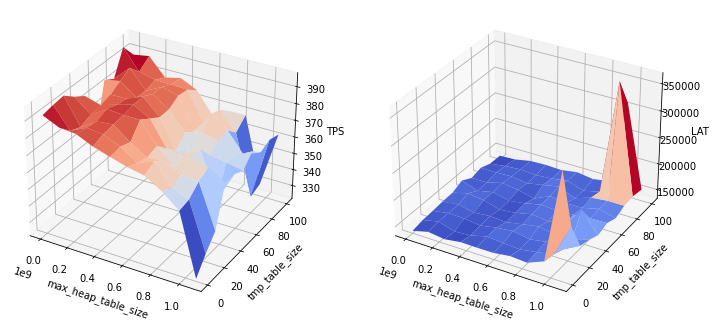

In [8]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import os
import json

def initialize_knobs(knobs_config_path):
    f = open(knobs_config_path)
    knob_tmp = json.load(f)
    KNOB_DETAILS = {}
    i = 0
    while i < len(knob_tmp.keys()):
        key = list(knob_tmp.keys())[i]
        KNOB_DETAILS[key] = knob_tmp[key]
        i = i + 1
    f.close()
    return KNOB_DETAILS

path = "/home/root3/Tuning/benchbase_tpcc_2_16_1705885331.1562111"
knob_path = "/home/root3/Tuning/mysql_knobs.json"
knob_details = initialize_knobs(knob_path)
file_path = os.path.join(path, "results_all.res")
with open(file_path, "r") as f:
    lines = f.readlines()
key1, key2 = list(eval(lines[1])["knobs"].keys())
x = np.linspace(knob_details[key1]["min"], knob_details[key1]["max"], 10, dtype=np.int32)
y = np.linspace(knob_details[key2]["min"], knob_details[key2]["max"], 10, dtype=np.int32)
Y, X = np.meshgrid(y, x)
z1, Z1 = [], []
z2, Z2 = [], []
for i in range(1, len(lines)):
    line = lines[i]
    info = eval(line)
    z1.append(info["Throughput (requests/second)"])
    z2.append(info["Latency Distribution"]["99th Percentile Latency (microseconds)"])
    if len(z1) == 10:
        Z1.append(z1)
        z1 = []
    if len(z2) == 10:
        Z2.append(z2)
        z2 = []
Z1 = np.array(Z1)
Z2 = np.array(Z2)
# 创建三维图像对象
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
# 绘制曲面
ax1.plot_surface(X, Y, Z1, cmap=plt.get_cmap("coolwarm"))
ax2.plot_surface(X, Y, Z2, cmap=plt.get_cmap("coolwarm"))
# 设置轴标签
ax1.set_xlabel('max_heap_table_size')
ax1.set_ylabel('tmp_table_size')
ax1.set_zlabel('TPS')

ax2.set_xlabel('max_heap_table_size')
ax2.set_ylabel('tmp_table_size')
ax2.set_zlabel('LAT')
 
# 显示图像
plt.show()

In [3]:
import pandas as pd

df = pd.read_csv("/home/root3/KnobTuning/benchbase-mysql/tpcc_2024-01-21_05-27-36.samples.csv")
df.head()


,Time (seconds),Requests,Throughput (requests/second),Minimum Latency (microseconds),25th Percentile Latency (microseconds),Median Latency (microseconds),Average Latency (microseconds),75th Percentile Latency (microseconds),90th Percentile Latency (microseconds),95th Percentile Latency (microseconds),99th Percentile Latency (microseconds),Maximum Latency (microseconds)
0,0,152,152.0,1342,100128,116527,109651,137450,157100,165934,182235,185647
1,1,167,167.0,890,95838,111387,98048,118902,125153,126227,132492,132817
2,2,173,173.0,749,84827,100326,90811,107344,118109,125973,132877,134442
3,3,192,192.0,141,82027,93453,84882,108660,122786,127802,138897,140540
4,4,190,190.0,77,82410,93436,82588,101790,105491,108488,115970,118374


In [9]:
print(df["Throughput (requests/second)"].mean(), df["Throughput (requests/second)"].std())
print(df["95th Percentile Latency (microseconds)"].mean(), df["95th Percentile Latency (microseconds)"].std())

191.23333333333332 11.845569387931246
120496.96666666666 14156.103347986342
